In [1]:
import os
from datetime import datetime,timedelta 

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tqdm import tqdm_notebook
from evaluation import forecast_accuracy
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (20, 7)

In [2]:
df = pd.read_pickle('../dataset/preprocessed/group_imputed.pkl')

In [3]:
def colToRows(dx,attr):
    # DBA as attributes 
    dx = dx.pivot(index='DOA', columns='DBA', values=attr)
    # Removing sub index from Dataframe
    dx = dx.rename_axis(None, axis = 0)
    cols = {col:attr+str(int(col+1)).zfill(2) for col in dx.columns }
    # renaming columns
    dx = dx.rename(columns=cols)
    return dx.rename(columns={'ROH01':'ROH'}).sort_index(axis=1 ,ascending=False)

def preprocess(dx, cutoff = [0, 1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]):
    dx = dx.rename(columns={'ROH_med':'ROH'})
    dx['DOA'] = pd.to_datetime(dx['DOA'])
    # dx['DBA'] = 89 - dx['DBA']
    dx = dx[dx.DBA.isin(cutoff)]
    # dx['OCC'] = dx['ROH']/dx['Rooms']

    attributes = ['LAR_max', 'LAR_min', 'LAR_med', 'LAR_avg', 'LAR_std', 'ROH_max', 'ROH_min', 'ROH_avg', 'ROH_std', 'ROH']
    result = pd.DataFrame()
    for attribute in attributes:
        temp = colToRows(dx,attribute)
        result = pd.concat([result, temp],axis=1)

    result['DOW'] = result.index.dayofweek
    result['Mon'] = result.index.month
    result['Day'] = result.index.day
    # standardizing prices
    scaler = StandardScaler()
    result[result.columns] = scaler.fit_transform(result[result.columns])
    return result

def train_test_split(dx):
    index = int(len(dx)*0.8)
    train = dx[:index]
    test  = dx[index:]
    return train,test

def plot_train_test(train, test):
    plt.plot(train.index, train['ROH'], label='Train')
    plt.plot(test.index, test['ROH'], label='Test')
    plt.xlabel('DOA')
    plt.ylabel('ROH')
    plt.legend(loc='best')
    plt.show()

def plot_result(dx):
    plt.plot(dx.index, dx['ROH'], label='test')
    plt.plot(dx.index, dx['PRED'], label='LSTM')
    plt.xlabel('DOA')
    plt.ylabel('ROH')
    plt.legend(loc='best')
    plt.show()

# @ref: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

def createModel(X,y):
    n_features = X.shape[2]
    n_steps = X.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=200, verbose=0)
    return model

In [4]:
data = preprocess(df)
train,test = train_test_split(data)
train.head(10)

DBA,LAR_max90,LAR_max60,LAR_max30,LAR_max21,LAR_max14,LAR_max07,LAR_max06,LAR_max05,LAR_max04,LAR_max03,...,ROH07,ROH06,ROH05,ROH04,ROH03,ROH02,ROH,DOW,Mon,Day
2018-01-01,-0.579274,-0.674789,-0.614265,-0.612532,-0.626277,-0.627944,-0.624270,-0.622190,-0.618842,-0.611286,...,-0.046818,-0.025862,-0.006252,-0.035586,-0.017722,0.490756,0.025675,-1.495304,-1.602745,-1.673503
2018-01-02,-1.112558,-0.921149,-0.878649,-0.878124,-0.901045,-0.903967,-0.897497,-0.894342,-0.891459,-0.883955,...,-0.348890,-0.328965,-0.310520,-0.296231,-0.279952,-0.260111,0.069775,-0.995729,-1.602745,-1.559818
2018-01-03,-0.712595,-1.290690,-1.407416,-1.409308,-1.450580,-1.456012,-1.443952,-1.438645,-1.436693,-1.429291,...,-0.650962,-0.675369,-0.658254,-0.643757,-0.629593,-0.613460,-0.591729,-0.496154,-1.602745,-1.446134
2018-01-04,0.087332,-1.044329,-1.407416,-1.409308,-1.450580,-1.456012,-1.443952,-1.438645,-1.436693,-1.429291,...,-0.564656,-0.545467,-0.527854,-0.513435,-0.498477,-0.480954,-0.459428,0.003422,-1.602745,-1.332449
2018-01-05,-0.979237,-1.167510,-1.143032,-1.143716,-1.175812,-1.179989,-1.170725,-1.166494,-1.164076,-1.156623,...,-0.866728,-0.848571,-0.832121,-0.817520,-0.804413,-0.790135,-0.768130,0.502997,-1.602745,-1.218764
2018-01-06,-0.979237,-0.921149,-1.143032,-1.143716,-1.175812,-1.179989,-1.170725,-1.166494,-1.164076,-1.156623,...,-1.255106,-1.238275,-1.223322,-1.208488,-1.197759,-1.187653,-1.165032,1.002573,-1.602745,-1.105079
2018-01-07,-1.245879,-1.290690,-1.407416,-1.409308,-1.450580,-1.456012,-1.443952,-1.438645,-1.436693,-1.429291,...,-1.168800,-1.151674,-1.136389,-1.121606,-1.110349,-1.099315,-1.076832,1.502148,-1.602745,-0.991394
2018-01-08,-0.979237,-1.044329,-1.143032,-1.143716,-1.175812,-1.179989,-1.170725,-1.166494,-1.164076,-1.156623,...,-1.341413,-1.324876,-1.310256,-1.295369,-1.285169,-1.320159,-1.297333,-1.495304,-1.602745,-0.877709
2018-01-09,-0.712595,-1.044329,-1.143032,-1.143716,-1.175812,-1.179989,-1.170725,-1.166494,-1.164076,-1.156623,...,-1.427719,-1.411477,-1.397189,-1.382251,-1.372579,-1.364327,-1.341433,-0.995729,-1.602745,-0.764024
2018-01-10,-0.072654,-1.044329,-1.143032,-1.143716,-1.175812,-1.179989,-1.170725,-1.166494,-1.164076,-1.156623,...,-1.341413,-1.324876,-1.310256,-1.295369,-1.285169,-1.275990,-1.253233,-0.496154,-1.602745,-0.650340


In [5]:
# choose a number of time steps
n_steps = 1
train_X, train_y = split_sequences(train.values, n_steps)
test_X, test_y = split_sequences(test.values, n_steps)

In [6]:
model = createModel(train_X, train_y)
test['PRED'] = model.predict(test_X)

<ipython-input-6-3f217b399bd7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['PRED'] = model.predict(test_X)


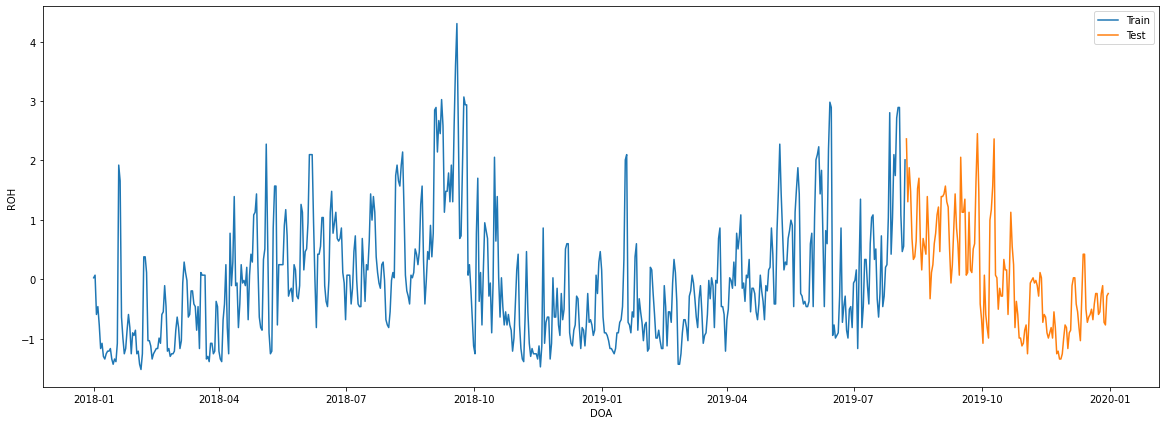

In [7]:
plot_train_test(train, test)

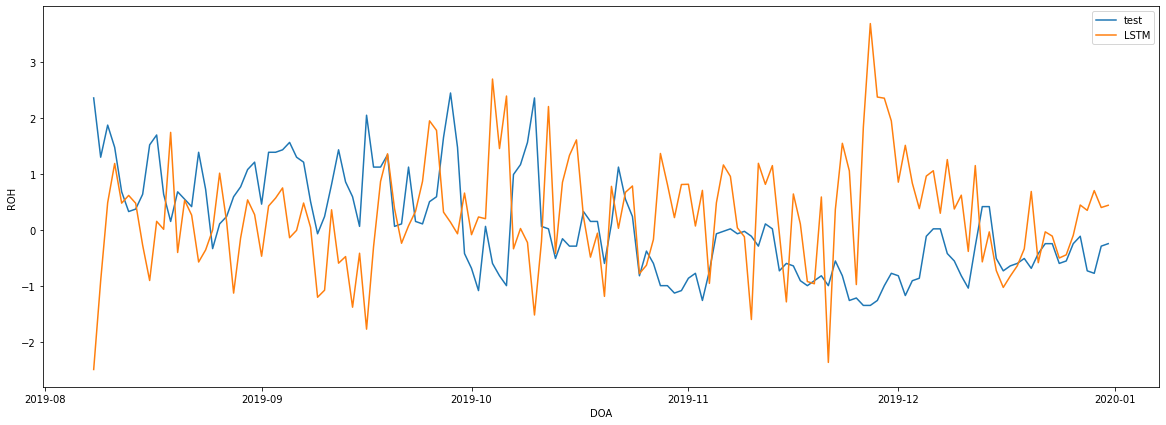

In [8]:
plot_result(test)

In [9]:
forecast_accuracy(test['PRED'],test_y)

1.3369	&	1.2362	&	1.1128	&	299.8872	&	1.3499	&	1.8222	&	-0.8895


## Combined 

In [5]:
cuttoffs = [1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]
for i in range(0,len(cuttoffs)):
    print('- DBA ',i)
    print([0]+cuttoffs[i:])

    df = pd.read_pickle('../dataset/preprocessed/group_imputed.pkl')
    df = preprocess(df, [0]+cuttoffs[i:])
    train, test = train_test_split(df)
    # choose a number of time steps
    n_steps = 1
    train_X, train_y = split_sequences(train.values, n_steps)
    test_X, test_y = split_sequences(test.values, n_steps)
    ## creating model
    model = createModel(train_X, train_y)
    test['PRED'] = model.predict(test_X)
    # plot_result(test)
    forecast_accuracy(test['PRED'],test_y)

- DBA  0
[0, 1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]
1.384	&	0.6081	&	1.1219	&	258.0883	&	1.3966	&	1.9504	&	-1.0224
- DBA  1
[0, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]
1.4159	&	0.73	&	1.0538	&	280.2553	&	1.4714	&	2.165	&	-1.245
- DBA  2
[0, 3, 4, 5, 6, 13, 20, 29, 59, 89]
1.192	&	0.6419	&	1.0054	&	287.4911	&	1.2368	&	1.5296	&	-0.5861
- DBA  3
[0, 4, 5, 6, 13, 20, 29, 59, 89]
1.144	&	-0.0018	&	0.9476	&	207.9186	&	1.2029	&	1.4469	&	-0.5004
- DBA  4
[0, 5, 6, 13, 20, 29, 59, 89]
1.2869	&	0.404	&	1.014	&	265.3757	&	1.3181	&	1.7374	&	-0.8016
- DBA  5
[0, 6, 13, 20, 29, 59, 89]
1.2561	&	0.0881	&	1.0232	&	251.3165	&	1.2845	&	1.6498	&	-0.7108
- DBA  6
[0, 13, 20, 29, 59, 89]
1.1576	&	0.5126	&	0.9108	&	219.3733	&	1.1849	&	1.4041	&	-0.456
- DBA  7
[0, 20, 29, 59, 89]
1.3081	&	0.6445	&	1.0369	&	251.7616	&	1.3107	&	1.7179	&	-0.7814
- DBA  8
[0, 29, 59, 89]
1.1475	&	0.5919	&	0.9218	&	219.981	&	1.1806	&	1.3937	&	-0.4452
- DBA  9
[0, 59, 89]
1.1325	&	0.7042	&	0.8967	&	250.0347	&	1.1654	&	1.3582	&	-0.4084
-